In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from simulate.simulate import simulate

from inference.loss_minibatch import LossMinibatch
from inference.train_minibatch import train_minibatch

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior

In [5]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [6]:
data, truth = simulate(use_torch=True)

In [15]:
run_name = 'artificial_mini_batch'

In [12]:
z_flow, theta_flow, hist_loss = train_minibatch(
    data, 
    optimizer_name='Adam',
    batch_size=1000, 
    n_sample=100,
    initial_lr=0.005, 
    flow_length=40, 
    n_epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

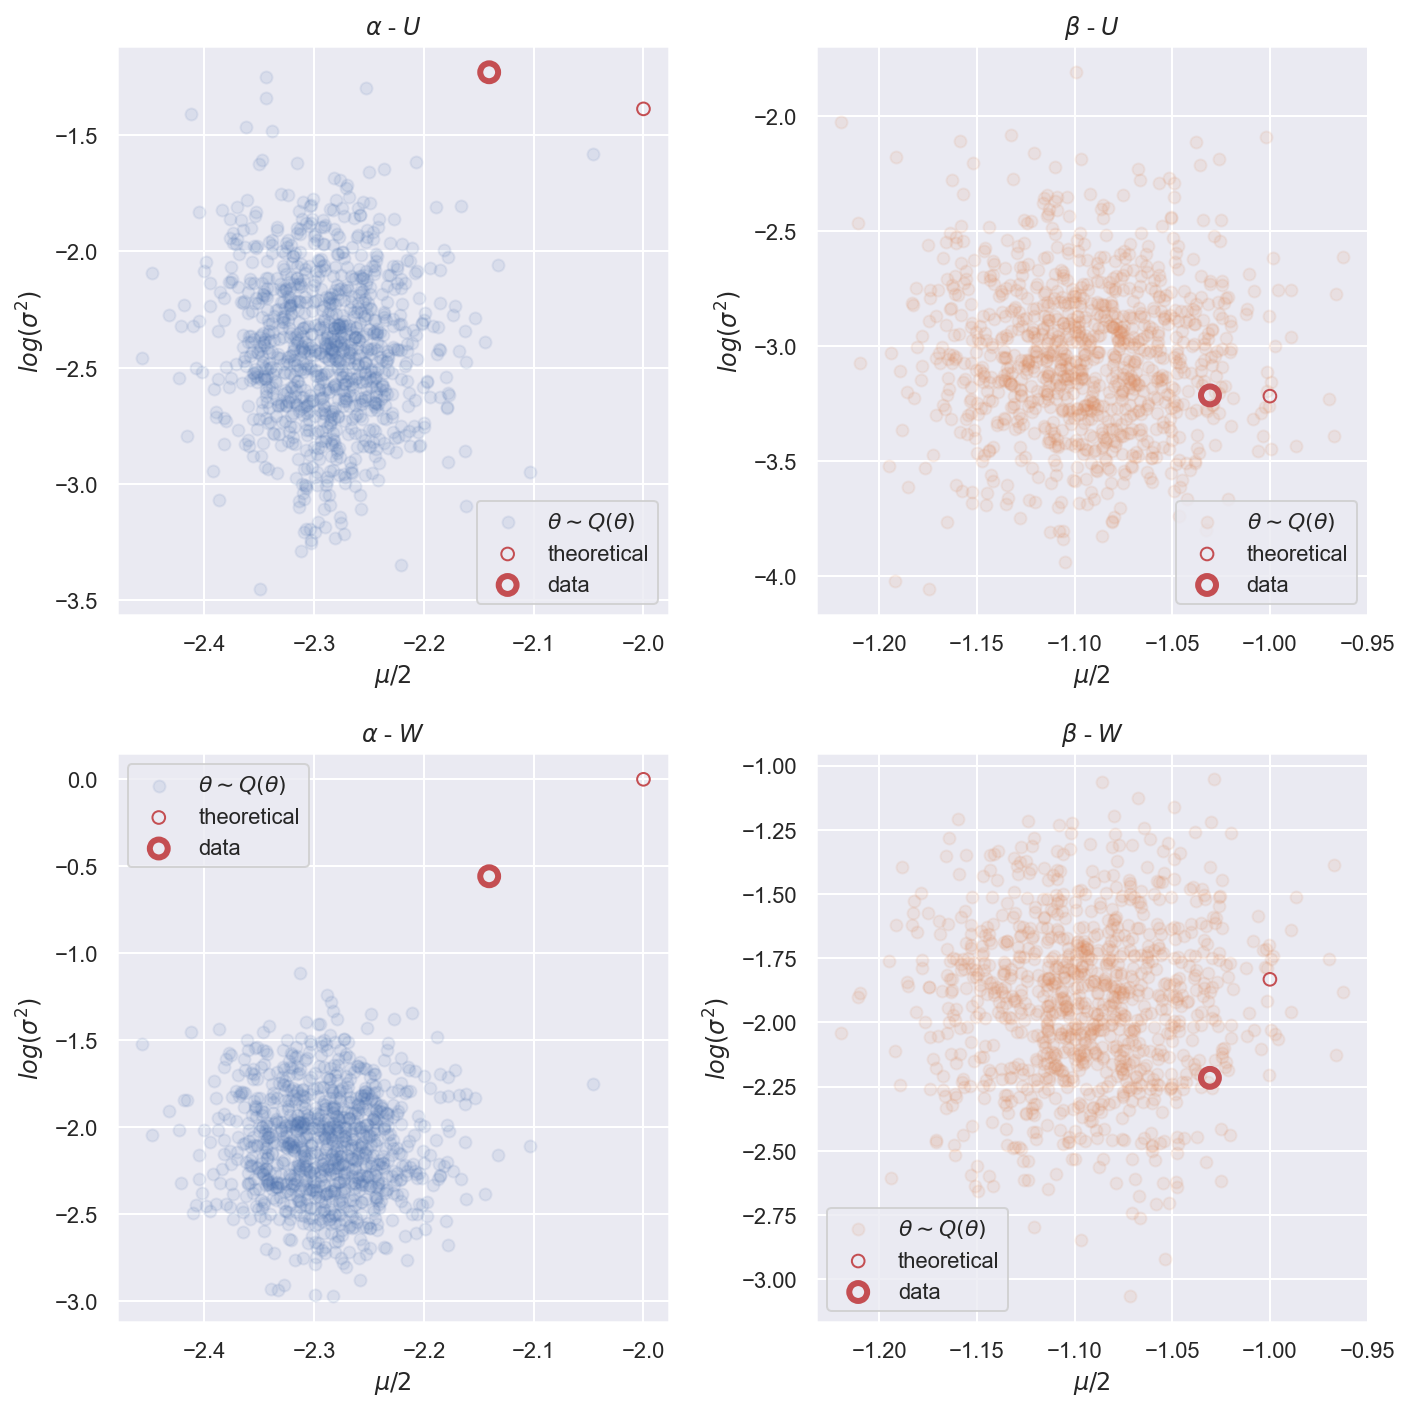

In [13]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name=run_name)

In [ ]:
z_flow.save(run_name) 
theta_flow.save(run_name)

# Test 2

In [7]:
run_name = "artificial_minibatch_rmsprop_opt"

In [8]:
z_flow, theta_flow, hist_loss = train_minibatch(
    data, 
    optimizer_name='RMSprop',
    batch_size=1000, 
    n_sample=50,
    initial_lr=0.001, 
    flow_length=33, 
    n_epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
z_flow.save(run_name) 
theta_flow.save(run_name)

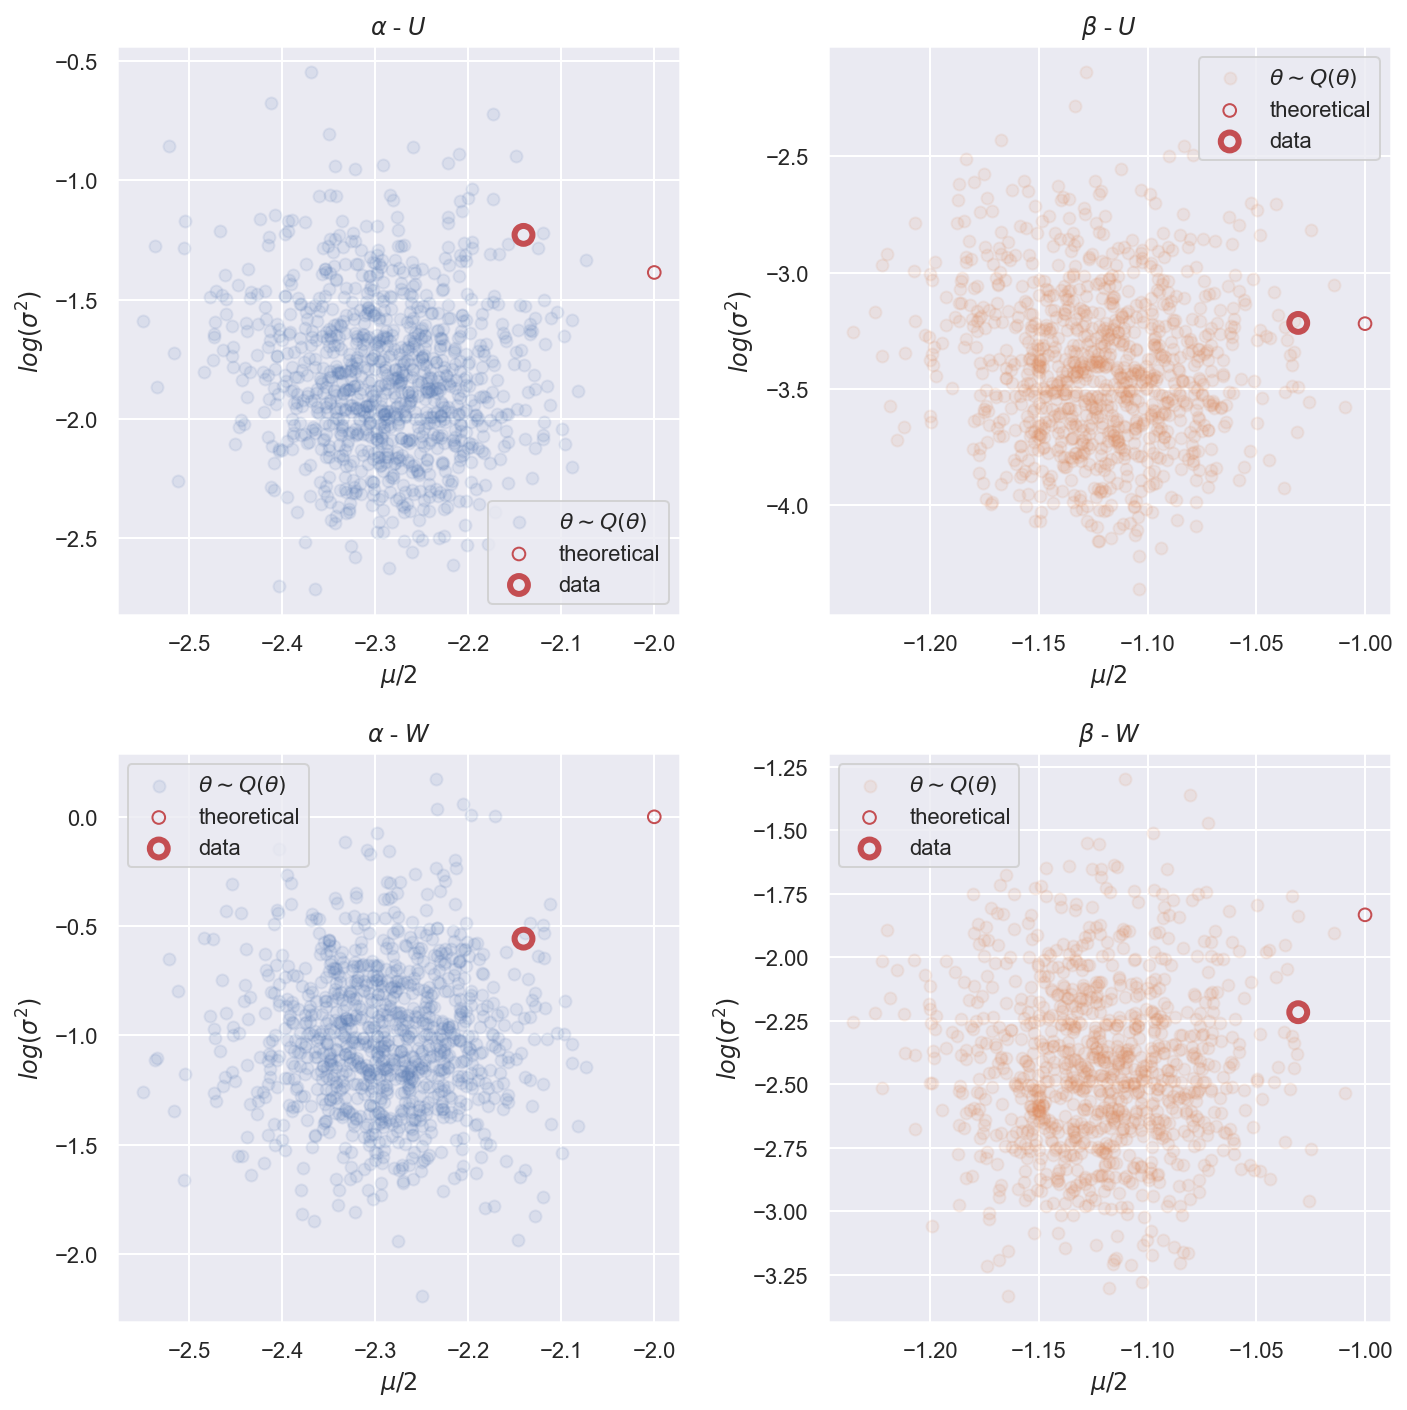

In [10]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name=run_name)

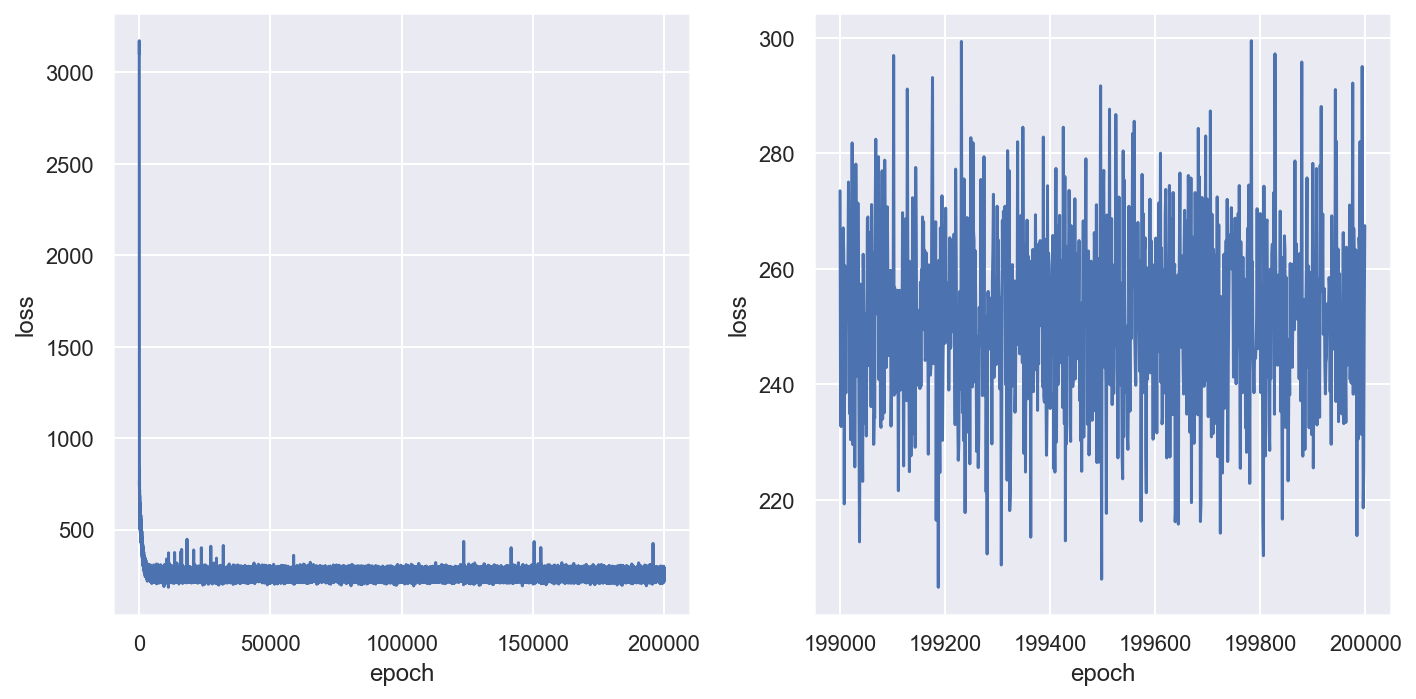

In [11]:
plot_loss(hist_loss)